# Import all of the packages needed 

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install -q efficientnet


In [ ]:
#Mounting google colab with google drive
from google.colab import drive,files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.
import matplotlib.pyplot as plt
import matplotlib.image as img
#Numpy library allows you to perform numerical calculations with Python. It introduces easier management of number tables.
import numpy as np
#inline to get the output graphs on this notebook and not on an external tab
%matplotlib inline

In [ ]:
#from scipy.misc import imresize
from PIL import Image
#numpy.array(Image.fromarray(arr).resize())

In [ ]:
#This module provides a portable way of using operating system dependent functionality.(to handle a file in  our case)
import os
from os import listdir
from os.path import isfile, join
#The shutil module offers a number of high-level operations on files and collections of files. 
#In particular, functions are provided which support file copying and removal. 
import shutil
import stat
import collections
from collections import defaultdict

In [ ]:
#Widgets are eventful python objects that have a representation in the browser, often as a control like a slider, textbox, etc.
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
#The h5py package is a Pythonic interface to the HDF5 binary data format.
import h5py
#scikit-learn is a Python module for machine learning built on top of SciPy.
from sklearn.model_selection import train_test_split



In [ ]:
#Ps: i have runtime error here 
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


# Download the dataset and extract it 

In [ ]:
#We can observe 11 classes of food categories in the traindata folder
!ls '/content/My Drive/drive/enit/training_data'

ls: cannot access '/content/My Drive/drive/enit/training_data': No such file or directory


In [ ]:
#visualize the 10 first images of the Meat category of the train data
!ls /tmp/traindata/Meat | head -10

0.jpg
1000.jpg
1001.jpg
1002.jpg
1003.jpg
1004.jpg
1005.jpg
1006.jpg
1007.jpg
1008.jpg


Let's look at some random images from each food class. You can right click and open the image in a new window or save it in order to see it at a higher resolution.

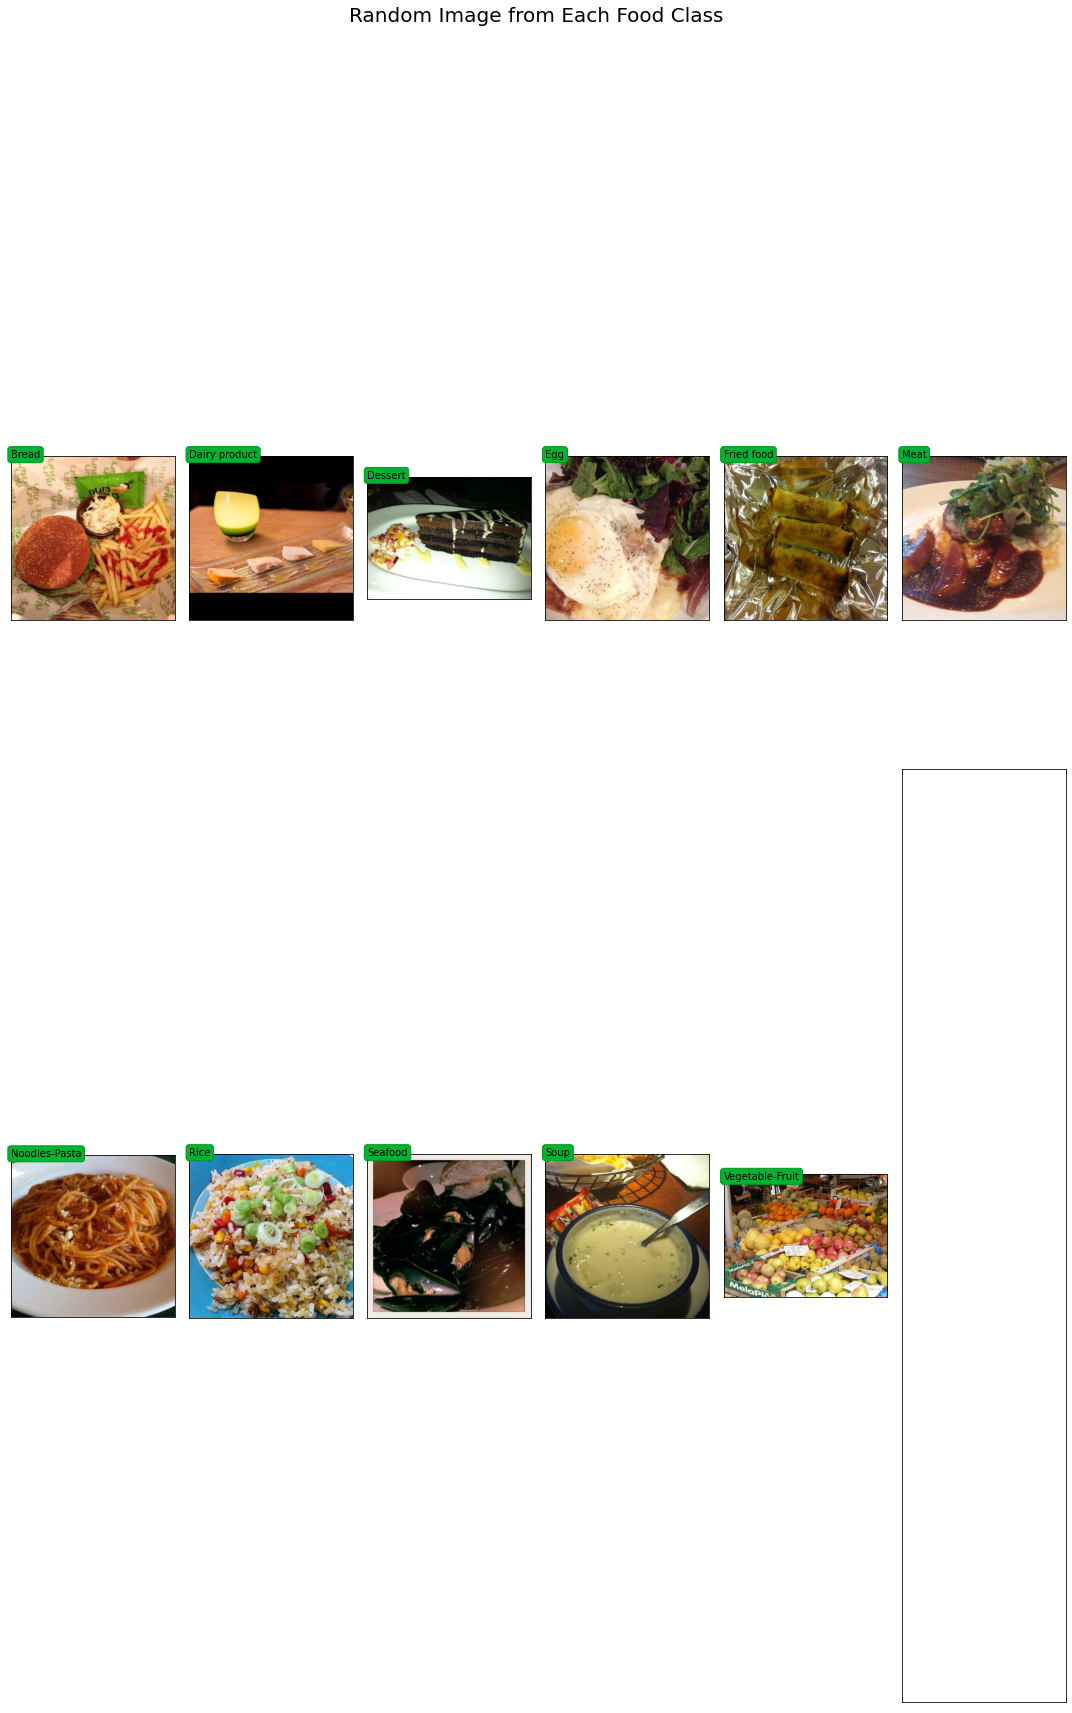

In [ ]:
root_dir = "/content/drive/My Drive/enit/training_data"
rows = 2
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
trainPath = '/content/drive/My Drive/enit/training_data'
validPath = '/content/drive/My Drive/enit/evaluation_data'
testPath  = '/content/drive/My Drive/enit/validation_data'

In [ ]:
ls /content/drive/My Drive/enit

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/enit': No such file or directory


We need maps from class to index and vice versa, for proper label encoding and pretty printing.

In [ ]:
class_to_ix = {}
ix_to_class = {}
with open('classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))
print(sorted_class_to_ix)

OrderedDict([('', 19), ('Bread', 0), ('Dairy product', 2), ('Dessert', 4), ('Egg', 6), ('Fried food', 8), ('Meat', 10), ('Noodles-Pasta', 12), ('Rice', 14), ('Seafood', 16), ('Soup', 18), ('Vegetable-Fruit', 20)])


In [ ]:
import os

In [ ]:
Foods = os.listdir(trainPath)
Foods.sort()
print(Foods)
labels = Foods

['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


# Prepare Data

In [ ]:
#a highly optimized library for numerical operations with a MATLAB-style syntax.
import numpy as np
#pip install opencv-python
#OpenCV-Python is a library of Python bindings designed to solve computer vision problems.
import cv2
#Converts a class vector (integers) to binary class matrix.
from tensorflow.keras.utils import to_categorical

#Visualize original Data

We are now ready to load the training and testing images into memory. After everything is loaded, 
Any images that have a width or length smaller than min_size will be resized. This is so that we can take proper-sized crops during image augmentation.

In [ ]:
%%time

# Load dataset images and resize to meet minimum width and height pixel size
def load_images(root, min_side=299):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        class_ix = class_to_ix[subdir]
        print(i, class_ix, subdir)
        for img_name in imgs:
            #img_arr = img.imread(join(root, subdir, img_name))
            img_arr = plt.imread(os.path.join(root, subdir, img_name))
            
            img_arr_rs = img_arr
            try:
                w, h, _ = img_arr.shape
                if w < min_side:
                    wpercent = (min_side/float(w))
                    hsize = int((float(h)*float(wpercent)))
                    #print('new dims:', min_side, hsize)
                    img_arr_rs = imresize(img_arr, (min_side, hsize))
                    resize_count += 1
                elif h < min_side:
                    hpercent = (min_side/float(h))
                    wsize = int((float(w)*float(hpercent)))
                    #print('new dims:', wsize, min_side)
                    img_arr_rs = imresize(img_arr, (wsize, min_side))
                    resize_count += 1
                all_imgs.append(img_arr_rs)
                all_classes.append(class_ix)
            except:
                print('Skipping bad image: ', subdir, img_name)
                invalid_count += 1
    print(len(all_imgs), 'images loaded')
    print(resize_count, 'images resized')
    print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)
    
X_test, y_test = load_images('/content/drive/My Drive/enit/evaluation_data', min_side=299)

0 4 Dessert
Skipping bad image:  Dessert 124.jpg
Skipping bad image:  Dessert 185.jpg
Skipping bad image:  Dessert 102.jpg
Skipping bad image:  Dessert 143.jpg
Skipping bad image:  Dessert 231.jpg
Skipping bad image:  Dessert 36.jpg
Skipping bad image:  Dessert 418.jpg
Skipping bad image:  Dessert 81.jpg
Skipping bad image:  Dessert 220.jpg
Skipping bad image:  Dessert 57.jpg
Skipping bad image:  Dessert 74.jpg
Skipping bad image:  Dessert 488.jpg
Skipping bad image:  Dessert 234.jpg
Skipping bad image:  Dessert 408.jpg
Skipping bad image:  Dessert 7.jpg
Skipping bad image:  Dessert 94.jpg
Skipping bad image:  Dessert 302.jpg
Skipping bad image:  Dessert 79.jpg
Skipping bad image:  Dessert 296.jpg
1 12 Noodles-Pasta
Skipping bad image:  Noodles-Pasta 66.jpg
Skipping bad image:  Noodles-Pasta 51.jpg
Skipping bad image:  Noodles-Pasta 119.jpg
Skipping bad image:  Noodles-Pasta 118.jpg
Skipping bad image:  Noodles-Pasta 64.jpg
2 16 Seafood
Skipping bad image:  Seafood 139.jpg
Skipping bad

In [ ]:
%%time
X_train, y_train = load_images('/content/drive/My Drive/enit/training_data', min_side=299)

0 18 Soup
Skipping bad image:  Soup 166.jpg
Skipping bad image:  Soup 1484.jpg
Skipping bad image:  Soup 383.jpg
Skipping bad image:  Soup 455.jpg
Skipping bad image:  Soup 397.jpg
Skipping bad image:  Soup 25.jpg
Skipping bad image:  Soup 601.jpg
Skipping bad image:  Soup 39.jpg
Skipping bad image:  Soup 416.jpg
Skipping bad image:  Soup 395.jpg
Skipping bad image:  Soup 98.jpg
Skipping bad image:  Soup 984.jpg
Skipping bad image:  Soup 704.jpg
Skipping bad image:  Soup 727.jpg
Skipping bad image:  Soup 808.jpg
Skipping bad image:  Soup 948.jpg
Skipping bad image:  Soup 973.jpg
Skipping bad image:  Soup 812.jpg
Skipping bad image:  Soup 763.jpg
Skipping bad image:  Soup 698.jpg
Skipping bad image:  Soup 941.jpg
Skipping bad image:  Soup 680.jpg
Skipping bad image:  Soup 957.jpg
Skipping bad image:  Soup 705.jpg
Skipping bad image:  Soup 1159.jpg
Skipping bad image:  Soup 1096.jpg
Skipping bad image:  Soup 108.jpg
Skipping bad image:  Soup 1097.jpg
Skipping bad image:  Soup 1051.jpg
Sk

In [ ]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (9620,)
y_train shape (9620,)
X_test shape (1803,)
y_test shape (1803,)


# Visualization Tools

In [ ]:
#Dynamic dashbord
@interact(n=(0, len(X_train)))
def show_pic(n):
    plt.imshow(X_train[n])
    print('class:', y_train[n], ix_to_class[y_train[n]])

interactive(children=(IntSlider(value=4805, description='n', max=9611), Output()), _dom_classes=('widget-inter…

In [ ]:
#Dynamic dashbord
@interact(n=(0, len(X_test)))
def show_pic(n):
    plt.imshow(X_test[n])
    print('class:', y_test[n], ix_to_class[y_test[n]])

interactive(children=(IntSlider(value=1633, description='n', max=3266), Output()), _dom_classes=('widget-inter…

In [ ]:
#Dynamic dashbord
@interact(n_class=sorted_class_to_ix)
def show_random_images_of_class(n_class=0):
    print(n_class)
    nrows = 4
    ncols = 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(12, 8)
    #fig.tight_layout()
    imgs = np.random.choice((y_train == n_class).nonzero()[0], nrows * ncols)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(X_train[imgs[i]])
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    plt.show()

interactive(children=(Dropdown(description='n_class', index=1, options=OrderedDict([('', 19), ('Bread', 0), ('…

In [ ]:
#Dynamic dashbord
@interact(n_class=sorted_class_to_ix)
def show_random_images_of_class(n_class=0):
    print(n_class)
    nrows = 4
    ncols = 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(12, 8)
    #fig.tight_layout()
    imgs = np.random.choice((y_test == n_class).nonzero()[0], nrows * ncols)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(X_test[imgs[i]])
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    plt.show()

interactive(children=(Dropdown(description='n_class', index=1, options=OrderedDict([('', 19), ('Bread', 0), ('…

# Data Augmentation

Having a large dataset is crucial for the performance of the deep learning model. However, we can improve the performance of the model by augmenting the data we already have. 

In our case we will use keras ImageDataGeerator package.While the word “augment” means to make something “greater” or “increase” something (in this case, data), the Keras ImageDataGenerator class actually works by:

1-Accepting a batch of images used for training.

2-Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).

3-Replacing the original batch with the new, randomly transformed batch.

4-Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

In [ ]:
#ImageDataGenerator Generate batches of tensor image data with real-time data augmentation.
#The data will be looped over (in batches).
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
target_size=(224,224)
batch_size = 16

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    trainPath,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')

Found 9875 images belonging to 11 classes.


In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    validPath,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

Found 1853 images belonging to 11 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    testPath,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',    
    class_mode='categorical')

Found 3430 images belonging to 11 classes.


# Build Model


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, BatchNormalization, Activation, LeakyReLU, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import efficientnet.tfkeras as efn

In [ ]:
num_classes = 11
input_shape = (224,224,3)

In [ ]:
# Build Model
net = efn.EfficientNetB7(input_shape=input_shape, weights='imagenet', include_top=False)

# add two FC layers (with L2 regularization)
x = net.output
x = GlobalAveragePooling2D()(x)

x = Dense(256)(x)
x = Dense(11)(x)

# Output layer
out = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=net.input, outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [ ]:
# Compile Model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
## set Checkpoint : save best only, verbose on
#checkpoint = ModelCheckpoint("food11_vgg16.hdf5", monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_freq=1)

# Train Model

We will be retraining an efficientnet model, pretrained on ImageNet. The neural network architecture is shown below.

![alt text](https://miro.medium.com/max/1176/0*GW6hb6YwdWXQNDiu)

In [ ]:
num_train = 9866
num_valid = 3430
#here we choose to work with 11 epochs because it gives us the best results according to the accuracy and loss graphs as shown below
num_epochs= 17

In [ ]:
# Train Model
history1= model.fit_generator(train_generator,steps_per_epoch=num_train // batch_size,epochs=num_epochs, validation_data=valid_generator, validation_steps=num_valid // batch_size) #, callbacks=[checkpoint])

Epoch 1/17
616/616 [==============================] - 482s 783ms/step - loss: 1824937730572.8257 - acc: 0.1098 - val_loss: 1257671.3759 - val_acc: 0.2344
Epoch 2/17
616/616 [==============================] - 434s 705ms/step - loss: 186653.8180 - acc: 0.1135 - val_loss: 413.6346 - val_acc: 0.0000e+00
Epoch 3/17
616/616 [==============================] - 434s 705ms/step - loss: 247.2346 - acc: 0.1145 - val_loss: 369.5168 - val_acc: 0.0064
Epoch 4/17
551/616 [=========================>....] - ETA: 42s - loss: 169.6384 - acc: 0.1048

In [ ]:
# Plot training & validation accuracy values
plt.plot(history1.history['accuracy'], marker="o")
plt.plot(history1.history['val_accuracy'], marker="o")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history1.history['loss'], marker="o")
plt.plot(history1.history['val_loss'], marker="o")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper')

NameError: ignored

In [ ]:
model.save("khawla_model.h5")


In [ ]:
import tensorflow as tf
keras_file = "khawla_model.h5"

converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
tflite_model = converter.convert()
open("converted_model_khawla2.tflite", "wb").write(tflite_model)



Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 1041 variables.
INFO:tensorflow:Converted 1041 variables to const ops.


257383712

In [ ]:
!pip install tf-nightly
new_model=tf.keras.models.load_model("khawla_model.h5")
model.load_weights("khawla_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()
open("khawla_converted_model2.tflite", "wb").write(tflite_model)

In [ ]:

!pip install tf-nightly
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model("food11.h5")

tflite_model = converter.convert()


# Save Model

In [ ]:
## Save Model
model.save('newfood11.h5')

In [ ]:
from google.colab import files
files.download("newfood11.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate Model

At this point, we should have multiple trained models saved to disk. We can go through them and use the load_model function to load the model with the lowest loss / highest accuracy.

In [ ]:
score = model.evaluate(valid_generator)

215/215 [==============================] - 29s 135ms/step - loss: 0.4808 - accuracy: 0.8551


# Confusion Matrix (validation set)

A confusion matrix will plot each class label and how many times it was correctly labeled vs. the other times it was incorrectly labeled as a different class.

In [ ]:
#Confusion matrix, without normalization
predY=model.predict(valid_generator)
y_pred = np.argmax(predY,axis=1)
#y_label= [labels[k] for k in y_pred]
y_actual = valid_generator.classes
cm = confusion_matrix(y_actual, y_pred)
print(cm)

[[37  8 57 36 29 51 12 15 34 50 33]
 [20  8 13 19 10 14  2  4 15 24 15]
 [57 21 73 47 45 66 28 16 41 66 40]
 [33 14 42 39 30 39 15  6 35 50 24]
 [42 14 48 35 29 48  8  7 24 43 28]
 [50 22 70 48 40 54 21 12 39 64 29]
 [18 10 23 16  9 18  8  4 13 18 10]
 [ 9  5 14 14  9 11  4  6  5 11  8]
 [35 13 49 43 32 32 16 12 37 49 29]
 [50 21 82 55 37 67 22 24 33 66 43]
 [27  9 36 22 22 25  8  5 18 37 23]]


In [ ]:
print(classification_report(y_actual, y_pred, target_names=labels))

                 precision    recall  f1-score   support

          Bread       0.10      0.10      0.10       362
  Dairy product       0.06      0.06      0.06       144
        Dessert       0.14      0.15      0.14       500
            Egg       0.10      0.12      0.11       327
     Fried food       0.10      0.09      0.09       326
           Meat       0.13      0.12      0.12       449
  Noodles-Pasta       0.06      0.05      0.05       147
           Rice       0.05      0.06      0.06        96
        Seafood       0.13      0.11      0.12       347
           Soup       0.14      0.13      0.13       500
Vegetable-Fruit       0.08      0.10      0.09       232

       accuracy                           0.11      3430
      macro avg       0.10      0.10      0.10      3430
   weighted avg       0.11      0.11      0.11      3430



# Test Model

In [ ]:
score = model.evaluate(test_generator)

210/210 [==============================] - 28s 133ms/step - loss: 0.4197 - accuracy: 0.8754


# Confusion Matrix (test set)

In [ ]:
#Confusion matrix without normalization
predY=model.predict(test_generator)
y_pred = np.argmax(predY,axis=1)
#y_label= [labels[k] for k in y_pred]
y_actual = test_generator.classes
cm = confusion_matrix(y_actual, y_pred)
print(cm)

[[52 15 59 39 36 34 10 10 33 58 22]
 [16 10 22 11 13 21  8  6 10 19 12]
 [54 30 67 73 29 73 27 15 41 58 33]
 [40 14 54 36 23 43 10  6 31 48 30]
 [36  9 33 36 23 37 10 13 26 40 24]
 [48 20 54 49 37 44 23 19 37 63 38]
 [16  3 17 13 15 21 10  1 22 21  8]
 [12  2 14  7  8 14  1  0  9 16 13]
 [25  7 39 35 22 26 18 13 24 58 36]
 [46 31 68 54 36 73 20 14 35 74 49]
 [34  8 36 24 10 26  9  8 15 33 28]]


In [ ]:
print(classification_report(y_actual, y_pred, target_names=labels))

                 precision    recall  f1-score   support

          Bread       0.14      0.14      0.14       368
  Dairy product       0.07      0.07      0.07       148
        Dessert       0.14      0.13      0.14       500
            Egg       0.10      0.11      0.10       335
     Fried food       0.09      0.08      0.09       287
           Meat       0.11      0.10      0.10       432
  Noodles-Pasta       0.07      0.07      0.07       147
           Rice       0.00      0.00      0.00        96
        Seafood       0.08      0.08      0.08       303
           Soup       0.15      0.15      0.15       500
Vegetable-Fruit       0.10      0.12      0.11       231

       accuracy                           0.11      3347
      macro avg       0.09      0.10      0.09      3347
   weighted avg       0.11      0.11      0.11      3347



# Model Evaluation



In [ ]:
from keras.models import Sequential, Model, load_model


In [ ]:

#model =load_model(filepath='/content/drive/My Drive/stageYobitrust2020/examples/Food11/Models/food11.h5')
model =load_model(filepath='newfood11.h5')#  0.8754 10-crop Top-1 test accuracy

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

## Model Evaluation¶

At this point, we should have multiple trained models saved to disk. We can go through them and use the load_model function to load the model with the lowest loss / highest accuracy.

In [ ]:
model2 =load_model(filepath='/content/drive/My Drive/stageYobitrust2020/examples/Food11/Models/food11.h5')

In [ ]:
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

We also want to evaluate the test set using multiple crops. This can yield an accuracy boost of 5% compared to single crop evaluation. It is common to use the following crops: Upper Left, Upper Right, Lower Left, Lower Right, Center. We also take the same crops on the image flipped left to right, creating a total of 10 crops.

In addition, we want to return the top-N predictions for each crop in order to calculate Top-5 accuracy, for instance.

In [ ]:
def center_crop(x, center_crop_size, **kwargs):
    centerw, centerh = x.shape[0]//2, x.shape[1]//2
    halfw, halfh = center_crop_size[0]//2, center_crop_size[1]//2
    return x[centerw-halfw:centerw+halfw+1,centerh-halfh:centerh+halfh+1, :]

In [ ]:
def predict_10_crop(img, ix, top_n=5, plot=False, preprocess=True, debug=False):
    flipped_X = np.fliplr(img)
    crops = [
        img[:299,:299, :], # Upper Left
        img[:299, img.shape[1]-299:, :], # Upper Right
        img[img.shape[0]-299:, :299, :], # Lower Left
        img[img.shape[0]-299:, img.shape[1]-299:, :], # Lower Right
        center_crop(img, (299, 299)),
        
        flipped_X[:299,:299, :],
        flipped_X[:299, flipped_X.shape[1]-299:, :],
        flipped_X[flipped_X.shape[0]-299:, :299, :],
        flipped_X[flipped_X.shape[0]-299:, flipped_X.shape[1]-299:, :],
        center_crop(flipped_X, (299, 299))
    ]
    if preprocess:
        crops = [preprocess_input(x.astype('float32')) for x in crops]

    if plot:
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))
        ax[0][0].imshow(crops[0])
        ax[0][1].imshow(crops[1])
        ax[0][2].imshow(crops[2])
        ax[0][3].imshow(crops[3])
        ax[0][4].imshow(crops[4])
        ax[1][0].imshow(crops[5])
        ax[1][1].imshow(crops[6])
        ax[1][2].imshow(crops[7])
        ax[1][3].imshow(crops[8])
        ax[1][4].imshow(crops[9])
    
    y_pred = model.predict(np.array(crops))
    preds = np.argmax(y_pred, axis=1)
    top_n_preds= np.argpartition(y_pred, -top_n)[:,-top_n:]
    if debug:
        print('Top-1 Predicted:', preds)
        print('Top-5 Predicted:', top_n_preds)
        print('True Label:', y_test[ix])
    return preds, top_n_preds

    


Top-1 Predicted: [2 2 5 5 5 2 2 2 5 5]
Top-5 Predicted: [[ 3  1  4  2 10]
 [ 3  1  4  2 10]
 [ 2  3  1  4  5]
 [ 2  3  1  4  5]
 [ 2  3  1  4  5]
 [ 3  1  4  2 10]
 [ 3  1  4  2 10]
 [ 3  1  4  2 10]
 [ 2  3  1  4  5]
 [ 2  3  1  4  5]]
True Label: 20


(array([2, 2, 5, 5, 5, 2, 2, 2, 5, 5]), array([[ 3,  1,  4,  2, 10],
        [ 3,  1,  4,  2, 10],
        [ 2,  3,  1,  4,  5],
        [ 2,  3,  1,  4,  5],
        [ 2,  3,  1,  4,  5],
        [ 3,  1,  4,  2, 10],
        [ 3,  1,  4,  2, 10],
        [ 3,  1,  4,  2, 10],
        [ 2,  3,  1,  4,  5],
        [ 2,  3,  1,  4,  5]]))

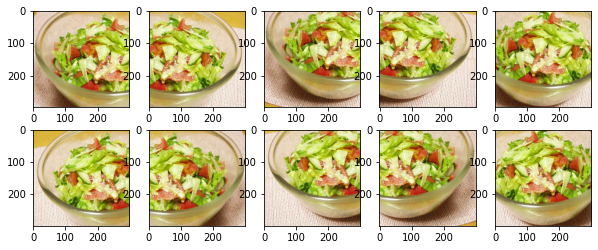

In [ ]:
ix = 32
predict_10_crop(X_test[ix], ix, top_n=5, plot=True, preprocess=False, debug=True)

We also need to preprocess the images for the Efficientnet model:

In [ ]:

from efficientnet.tfkeras import preprocess_input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Top-1 Predicted: [5 2 5 2 5 6 2 2 5 6]
Top-5 Predicted: [[3 0 6 2 5]
 [3 0 6 2 5]
 [3 0 6 2 5]
 [3 0 6 2 5]
 [3 0 6 2 5]
 [3 0 6 2 5]
 [3 0 6 2 5]
 [3 0 6 2 5]
 [3 0 6 2 5]
 [3 2 0 6 5]]
True Label: 20


(array([5, 2, 5, 2, 5, 6, 2, 2, 5, 6]), array([[3, 0, 6, 2, 5],
        [3, 0, 6, 2, 5],
        [3, 0, 6, 2, 5],
        [3, 0, 6, 2, 5],
        [3, 0, 6, 2, 5],
        [3, 0, 6, 2, 5],
        [3, 0, 6, 2, 5],
        [3, 0, 6, 2, 5],
        [3, 0, 6, 2, 5],
        [3, 2, 0, 6, 5]]))

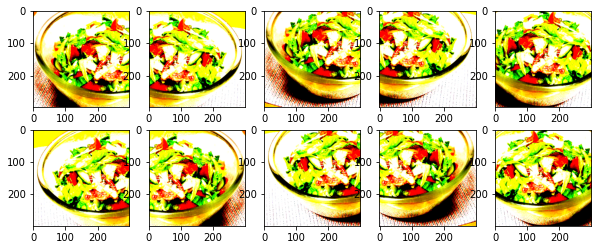

In [ ]:
ix = 32
predict_10_crop(X_test[ix], ix, top_n=5, plot=True, preprocess=True, debug=True)

Now we create crops for each item in the test set and get the predictions. This is a slow process at the moment as I am not taking advantage of multiprocessing or other types of parallelism.

In [ ]:
%%time
preds_10_crop = {}
for ix in range(len(X_test)):
    if ix % 1000 == 0:
        print(ix)
    preds_10_crop[ix] = predict_10_crop(X_test[ix], ix)

0
1000
2000
3000
CPU times: user 7min 24s, sys: 2min 55s, total: 10min 20s
Wall time: 9min 56s


We now have a set of 10 predictions for each image. Using a histogram, I'm able to see how the # of unique predictions for each image are distributed.

Text(0.5, 1.0, 'Number of unique predictions per image')

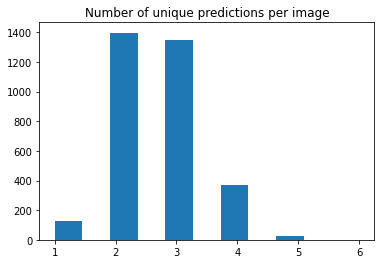

In [ ]:
preds_uniq = {k: np.unique(v[0]) for k, v in preds_10_crop.items()}
preds_hist = np.array([len(x) for x in preds_uniq.values()])

plt.hist(preds_hist, bins=11)
plt.title('Number of unique predictions per image')

Let's create a dictionary to map test item index to its top-1 / top-5 predictions.

In [ ]:
%%time
top_5_counter = 0
for i in range(len(y_test)):
    guesses, actual = preds_top_5[i], y_test[i]
    if actual in guesses:
        top_5_counter += 1
        
print('Top-5 Accuracy, 10-Crop: {0:.2f}%'.format(top_5_counter / len(y_test) * 100))

Top-5 Accuracy, 10-Crop: 27.80%
CPU times: user 2.25 ms, sys: 0 ns, total: 2.25 ms
Wall time: 2.22 ms


# Results Visualization

In [ ]:
y_pred = [x[0][0] for x in preds_top_1.values()]

Confusion matrix, without normalization
[[  0  13   0 268  77   1   0   2   0   0   0   0   0   0]
 [  0  11   0  93  39   0   0   2   0   0   0   0   0   0]
 [  0  42   0 263 171   3   0   2   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  16   0 230  79   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   6   0 222  56   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  29   2 199 192   1   0   1   0   0   0   0   0   0]
 [  0   8   0 107  25   0   0   2   0   0   0   0   0   0]
 [  0   2   0  69  18   0   0   2   3   0   0   0   0   0]
 [  0  44   1 140 104   4   0   1   0   0   0   0   0   0]
 [  0  35   2 260 188   0   0   6   3   0   0   0   0   0]
 [  0  29   2 104  83   0   0   4   0   0   0   0   0   0]]


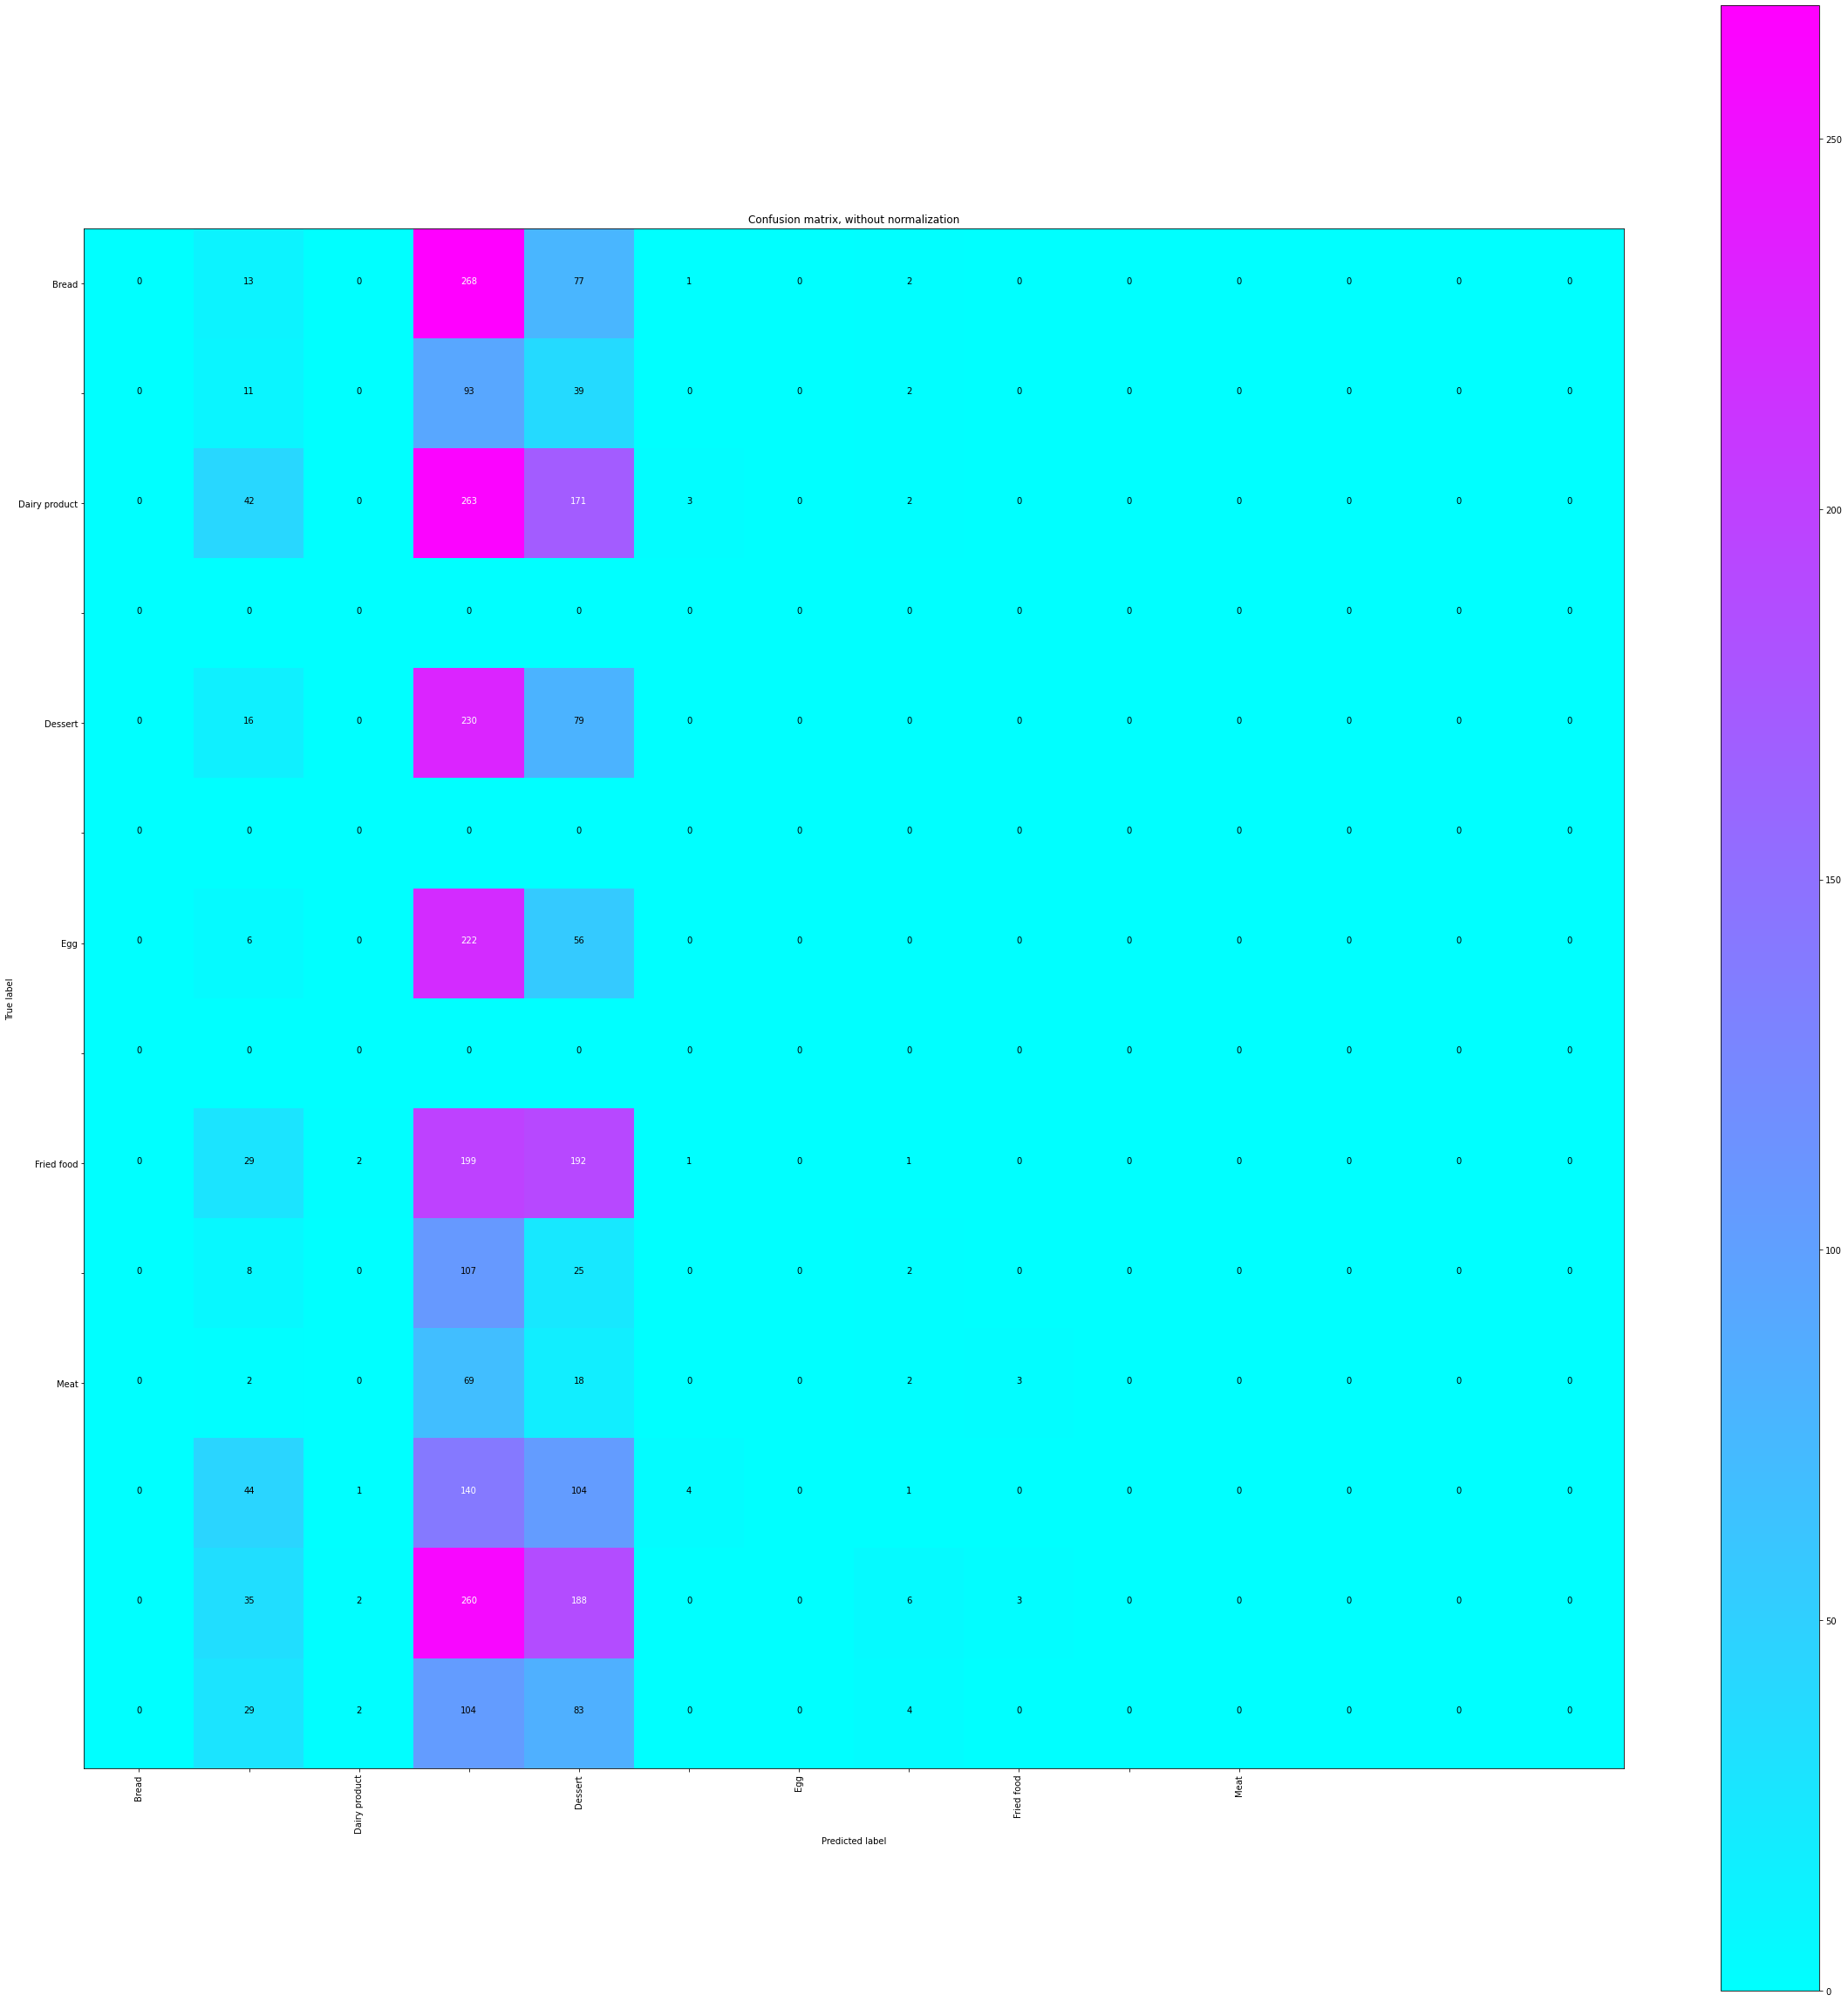

In [ ]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = [ix_to_class[i] for i in range(11)]

plt.figure()
fig = plt.gcf()
fig.set_size_inches(32, 32)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.cool)
plt.show()

We want to see if the accuracy was consistent across all classes, or if some classes were much easier / harder to label than others. According to our plot, a few classes were outliers in terms of being much more difficult to label correctly.

Text(0.5, 1.0, 'Accuracy by Class histogram')

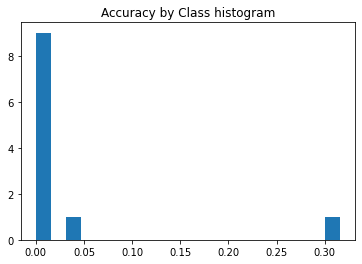

In [ ]:
corrects = collections.defaultdict(int)
incorrects = collections.defaultdict(int)
for (pred, actual) in zip(y_pred, y_test):
    if pred == actual:
        corrects[actual] += 1
    else:
        incorrects[actual] += 1

class_accuracies = {}
for ix in range(11):
    class_accuracies[ix] = corrects[ix]/250

plt.hist(list(class_accuracies.values()), bins=20)
plt.title('Accuracy by Class histogram')